In [1]:
import os
from glob import glob
import model.aotgan 
import torch
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from tqdm import tqdm
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image
from torch.utils.data import Dataset
import random
import numpy as np
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
from loss1 import loss as loss_module
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "5" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-06-04 09:06:33.550088: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 09:06:34.419612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
params={'image_size':512,
        'rates':[1, 2, 4, 8],
        'block_num':8,
        'model':'aotgan',
        'gan_type':"smgan",
        'lrg':2e-4,
        'lrd':2e-4,
        'beta1':0.5,
        'beta2':0.999,
        'batch_size':8,
        'epochs':1000,
        'data_path':'../../data/dataset/colon/',
        'num_workers':4,
        'rec_loss':'1*L1+250*Style+0.1*Perceptual'
        }
losses = list(params['rec_loss'].split("+"))
params['rec_loss'] = {}
for l in losses:
    weight, name = l.split("*")
    params['rec_loss'][name] = float(weight)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, args,dataset):
        super(Dataset, self).__init__()
        self.w = self.h = args['image_size']

        # image and mask
        self.image_path =glob(args['data_path']+dataset+'/image/*.png')
        self.mask_path = [i.replace('/image','/mask') for i in self.image_path]
        self.trans_1 = transforms.Compose(
            [
                transforms.Resize((args['image_size'],args['image_size']), interpolation=transforms.InterpolationMode.NEAREST)
            ]
        )
    def trans(self,image_t,a):
        image_t=F.to_tensor(F.rotate(self.trans_1(image_t),a))
        return image_t

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        # load image
        image = Image.open(self.image_path[index]).convert("RGB")
        filename = os.path.basename(self.image_path[index])
        mask = Image.open(self.mask_path[index])
        mask = mask.convert("L")
        # augment
        angle=random.randint(0, 360)
        
        image = self.trans(image,angle) * 2.0 - 1.0
        mask = self.trans(mask,angle)
        
        return image, mask, filename
    
train_dataset=CustomDataset(params,'train')
test_dataset=CustomDataset(params,'test')
train_dataloader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)
test_dataloader = DataLoader(
        test_dataset,
        batch_size=params['batch_size'],
         shuffle=True, drop_last=True)

In [4]:
netG =model.aotgan.InpaintGenerator(params).to(device)
optimG = torch.optim.Adam(netG.parameters(), lr=params['lrg'], betas=(params['beta1'], params['beta2']))

netD = model.aotgan.Discriminator().to(device)
optimD = torch.optim.Adam(netD.parameters(), lr=params['lrd'], betas=(params['beta1'], params['beta2']))
rec_loss_func = {key: getattr(loss_module, key)() for key, val in params['rec_loss'].items()}
adv_loss = getattr(loss_module, "smgan")()

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch: 1/1000 Step: 51 L1 loss : 0.2176 Style loss: 1.2551 Perceptual loss: 0.3363 advg loss: 0.4465 advd loss: 0.2543: 100%|██████████| 50/50 [01:22<00:00,  1.64s/it]
epoch: 2/1000 Step: 51 L1 loss : 0.1633 Style loss: 1.1314 Perceptual loss: 0.3360 advg loss: 0.4296 advd loss: 0.2241: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
epoch: 3/1000 Step: 51 L1 loss : 0.1744 Style loss: 1.1050 Perceptual loss: 0.3363 advg loss: 0.4470 advd loss: 0.2038: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]
epoch: 4/1000 Step: 51 L1 loss : 0.1563 Style loss: 1.0539 Perceptual loss: 0.3396 advg loss: 0.4335 advd loss: 0.2146: 100%|██████████| 50/50 [01:11<00:00,  1.44s/it]
epoch: 5/1000 Step: 51 L1 loss : 0.1549 Style loss: 0.9812 Perceptual loss: 0.3361 advg loss: 0.4364 advd loss: 0.1998: 100%|██████████| 50/50 [01:12<00:00,  1.46s/it]
epoch: 6/1000 Step: 51 L1 loss : 0.1522 Style loss: 0.9625 Perceptual loss: 0.3364 advg loss: 0.4375 advd loss: 0.2059: 100%|██████████| 50/50 [01:12<00:00,  1.

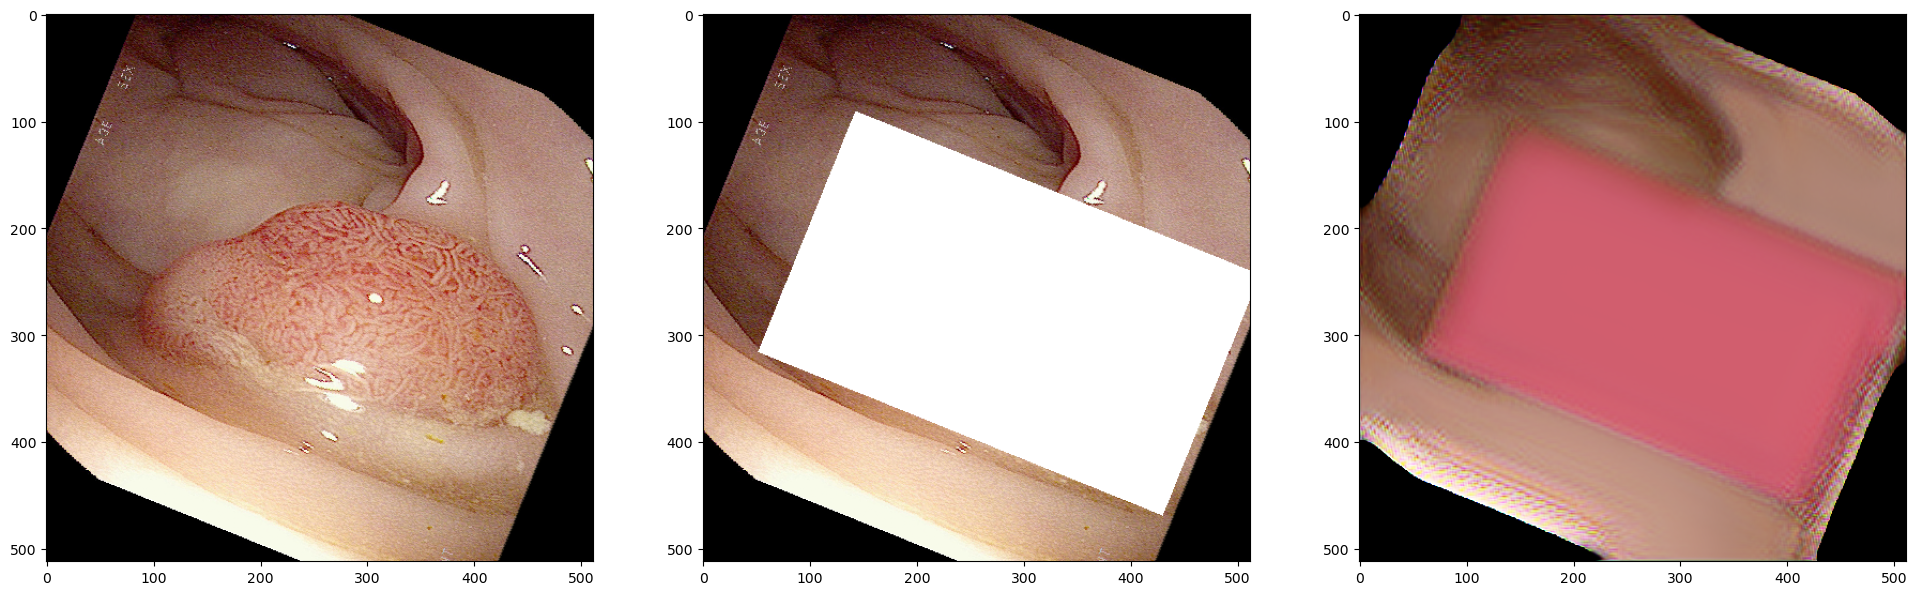

epoch: 7/1000 Step: 51 L1 loss : 0.1528 Style loss: 0.9035 Perceptual loss: 0.3352 advg loss: 0.4340 advd loss: 0.2036: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
epoch: 8/1000 Step: 51 L1 loss : 0.1528 Style loss: 0.8591 Perceptual loss: 0.3360 advg loss: 0.4318 advd loss: 0.1982: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
epoch: 9/1000 Step: 51 L1 loss : 0.1587 Style loss: 0.8804 Perceptual loss: 0.3409 advg loss: 0.4355 advd loss: 0.1968: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 10/1000 Step: 51 L1 loss : 0.1382 Style loss: 0.7806 Perceptual loss: 0.3320 advg loss: 0.4325 advd loss: 0.1952: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
epoch: 11/1000 Step: 51 L1 loss : 0.1295 Style loss: 0.7554 Perceptual loss: 0.3266 advg loss: 0.4319 advd loss: 0.1944: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]
epoch: 12/1000 Step: 51 L1 loss : 0.1265 Style loss: 0.7469 Perceptual loss: 0.3210 advg loss: 0.4282 advd loss: 0.1969: 100%|██████████| 50/50 [01:10<00:00, 

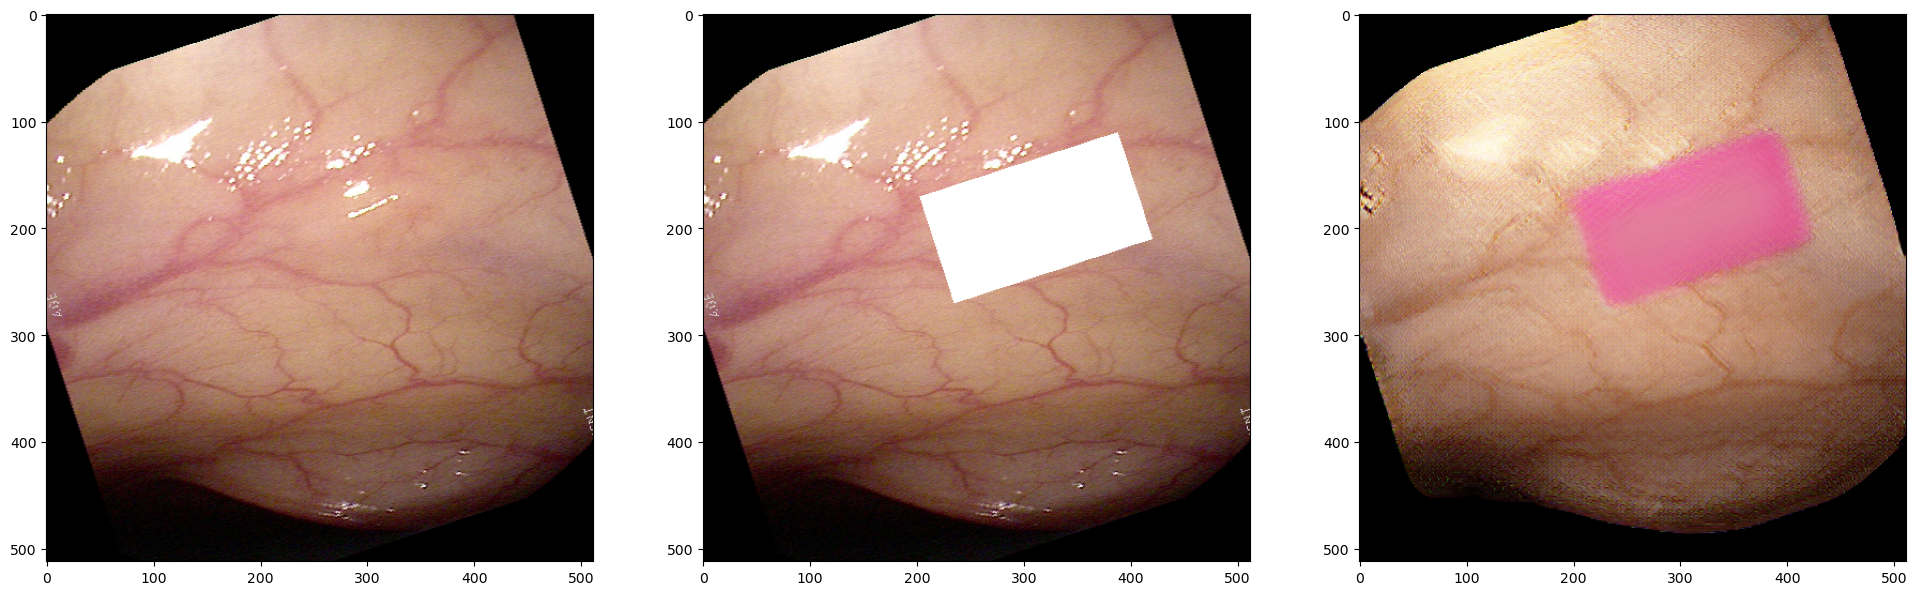

epoch: 17/1000 Step: 51 L1 loss : 0.1082 Style loss: 0.6689 Perceptual loss: 0.3022 advg loss: 0.4289 advd loss: 0.1937: 100%|██████████| 50/50 [01:10<00:00,  1.42s/it]
epoch: 18/1000 Step: 51 L1 loss : 0.1069 Style loss: 0.6493 Perceptual loss: 0.2959 advg loss: 0.4244 advd loss: 0.1945: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]
epoch: 19/1000 Step: 51 L1 loss : 0.1036 Style loss: 0.6311 Perceptual loss: 0.2892 advg loss: 0.4251 advd loss: 0.1941: 100%|██████████| 50/50 [01:02<00:00,  1.24s/it]
epoch: 20/1000 Step: 51 L1 loss : 0.1025 Style loss: 0.6204 Perceptual loss: 0.2863 advg loss: 0.4271 advd loss: 0.1929: 100%|██████████| 50/50 [01:01<00:00,  1.24s/it]
epoch: 21/1000 Step: 51 L1 loss : 0.1016 Style loss: 0.6165 Perceptual loss: 0.2857 advg loss: 0.4235 advd loss: 0.1944: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 22/1000 Step: 51 L1 loss : 0.1021 Style loss: 0.6020 Perceptual loss: 0.2833 advg loss: 0.4263 advd loss: 0.1937: 100%|██████████| 50/50 [01:01<00:0

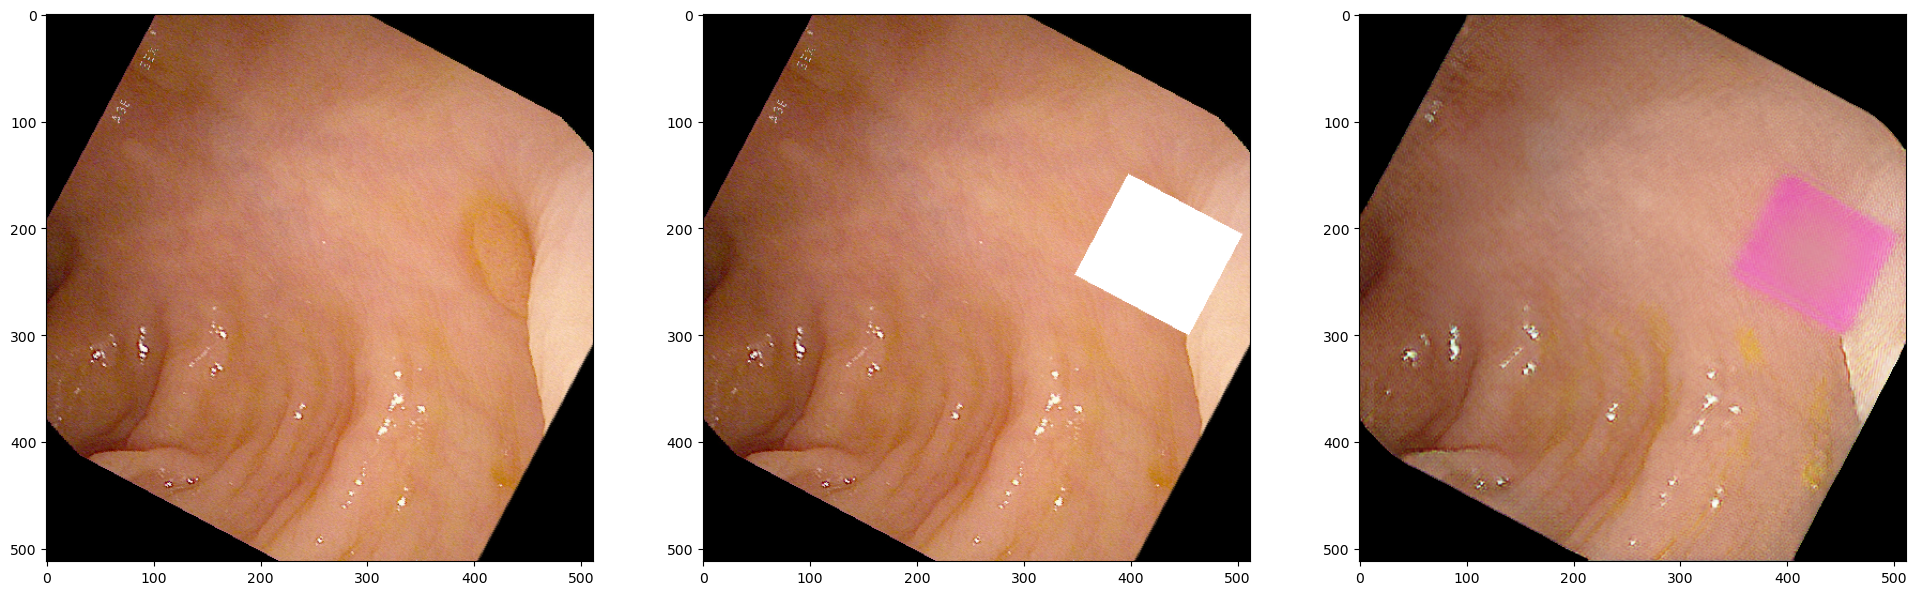

epoch: 27/1000 Step: 51 L1 loss : 0.0967 Style loss: 0.5650 Perceptual loss: 0.2751 advg loss: 0.4260 advd loss: 0.1953: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 28/1000 Step: 51 L1 loss : 0.0969 Style loss: 0.5623 Perceptual loss: 0.2743 advg loss: 0.4233 advd loss: 0.1949: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 29/1000 Step: 51 L1 loss : 0.0983 Style loss: 0.5588 Perceptual loss: 0.2748 advg loss: 0.4221 advd loss: 0.1938: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
epoch: 30/1000 Step: 51 L1 loss : 0.0948 Style loss: 0.5545 Perceptual loss: 0.2718 advg loss: 0.4222 advd loss: 0.1944: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
epoch: 31/1000 Step: 51 L1 loss : 0.0965 Style loss: 0.5389 Perceptual loss: 0.2704 advg loss: 0.4246 advd loss: 0.1950: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 32/1000 Step: 51 L1 loss : 0.1090 Style loss: 0.6059 Perceptual loss: 0.2840 advg loss: 0.4224 advd loss: 0.1978: 100%|██████████| 50/50 [01:01<00:0

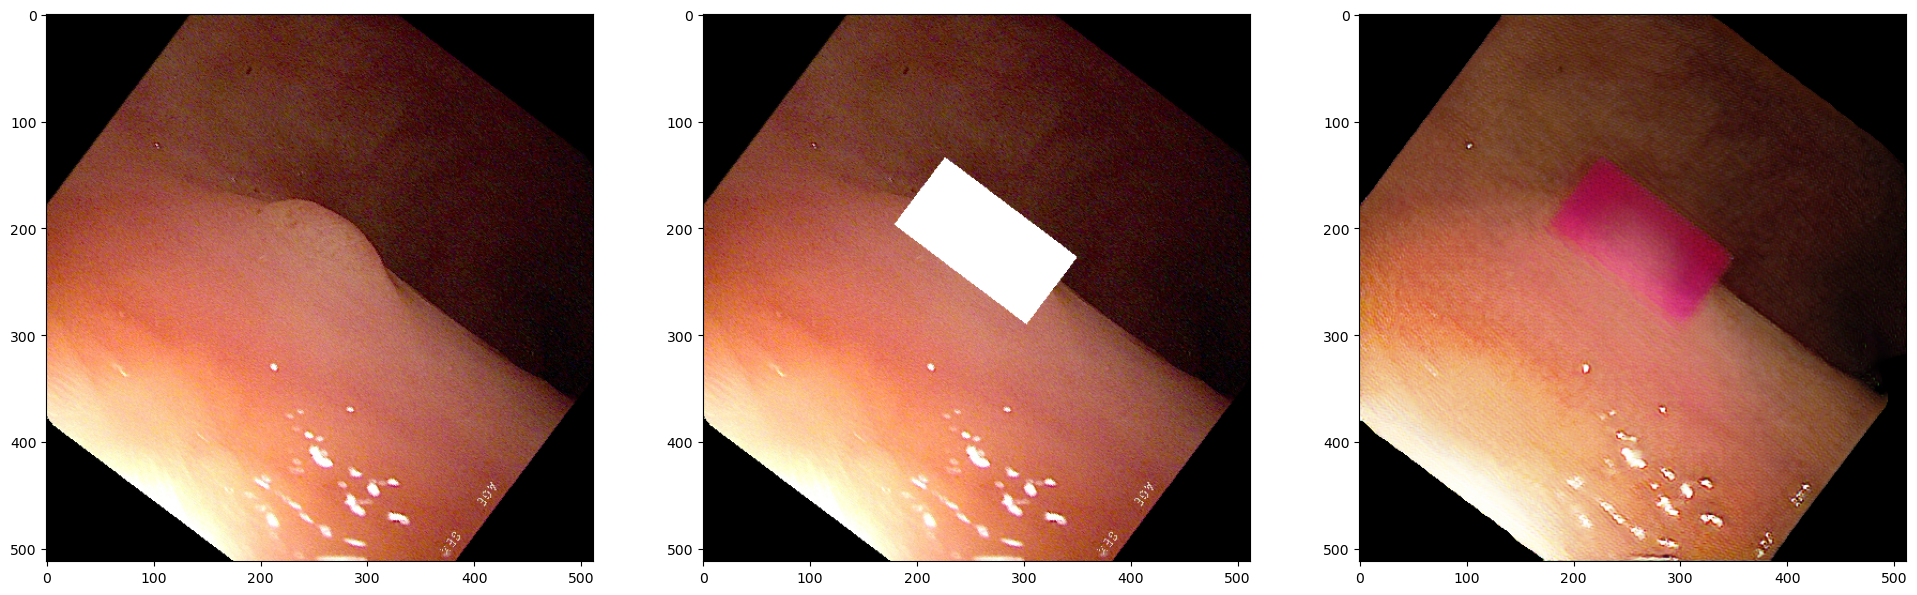

epoch: 37/1000 Step: 51 L1 loss : 0.0941 Style loss: 0.5025 Perceptual loss: 0.2663 advg loss: 0.4213 advd loss: 0.1952: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 38/1000 Step: 51 L1 loss : 0.0950 Style loss: 0.4994 Perceptual loss: 0.2667 advg loss: 0.4235 advd loss: 0.1955: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 39/1000 Step: 51 L1 loss : 0.0939 Style loss: 0.4844 Perceptual loss: 0.2646 advg loss: 0.4206 advd loss: 0.1947: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
epoch: 40/1000 Step: 51 L1 loss : 0.0944 Style loss: 0.4707 Perceptual loss: 0.2637 advg loss: 0.4194 advd loss: 0.1950: 100%|██████████| 50/50 [01:00<00:00,  1.22s/it]
epoch: 41/1000 Step: 51 L1 loss : 0.0947 Style loss: 0.4686 Perceptual loss: 0.2640 advg loss: 0.4206 advd loss: 0.1941: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 42/1000 Step: 51 L1 loss : 0.0919 Style loss: 0.4640 Perceptual loss: 0.2611 advg loss: 0.4191 advd loss: 0.1963: 100%|██████████| 50/50 [01:02<00:0

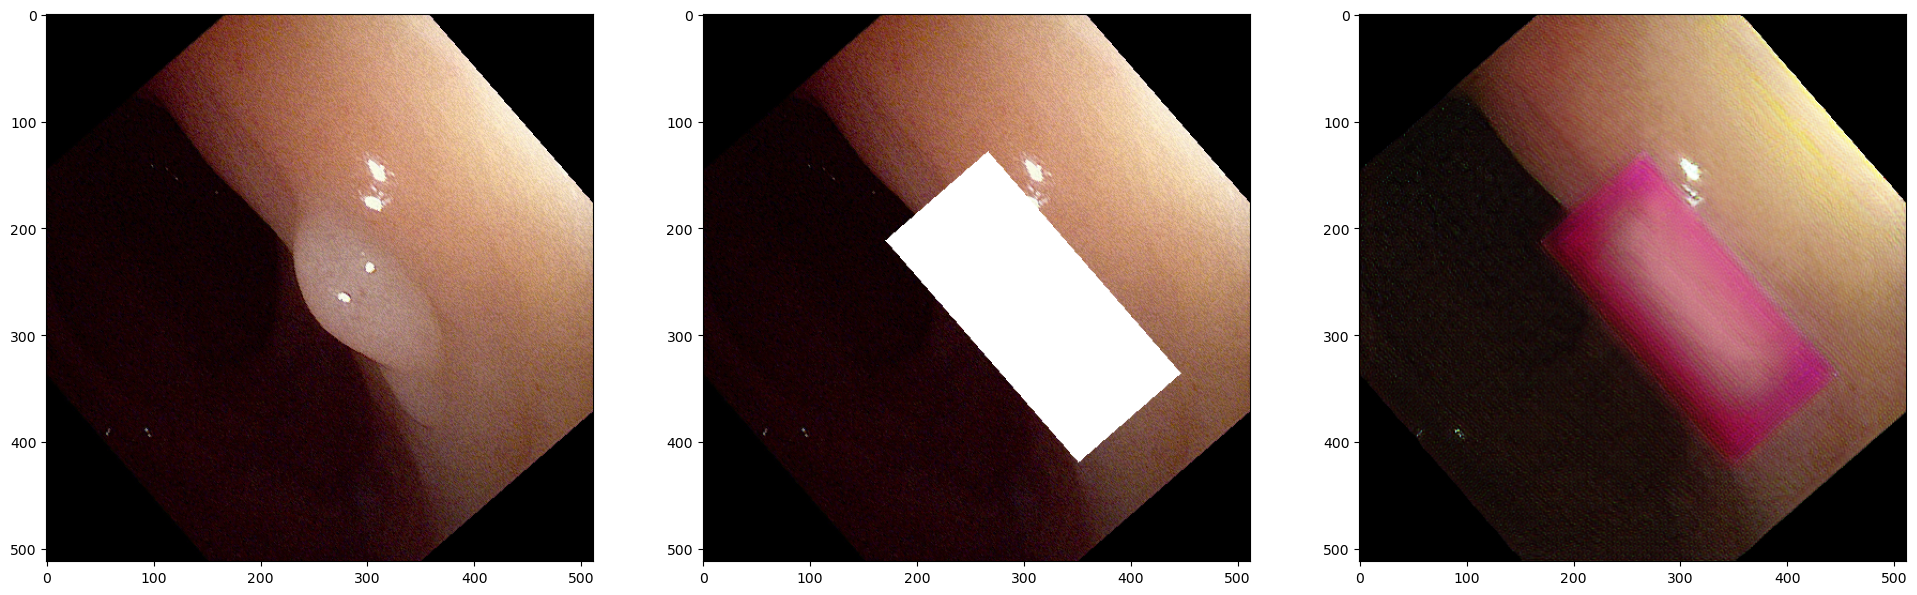

epoch: 47/1000 Step: 51 L1 loss : 0.0899 Style loss: 0.4266 Perceptual loss: 0.2559 advg loss: 0.4188 advd loss: 0.1954: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 48/1000 Step: 51 L1 loss : 0.0902 Style loss: 0.4131 Perceptual loss: 0.2553 advg loss: 0.4188 advd loss: 0.1946: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 49/1000 Step: 51 L1 loss : 0.0905 Style loss: 0.4175 Perceptual loss: 0.2539 advg loss: 0.4178 advd loss: 0.1956: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 50/1000 Step: 51 L1 loss : 0.0912 Style loss: 0.4195 Perceptual loss: 0.2570 advg loss: 0.4183 advd loss: 0.1957: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 51/1000 Step: 51 L1 loss : 0.0881 Style loss: 0.4045 Perceptual loss: 0.2534 advg loss: 0.4173 advd loss: 0.1955: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 52/1000 Step: 51 L1 loss : 0.0895 Style loss: 0.4165 Perceptual loss: 0.2555 advg loss: 0.4190 advd loss: 0.1953: 100%|██████████| 50/50 [01:01<00:0

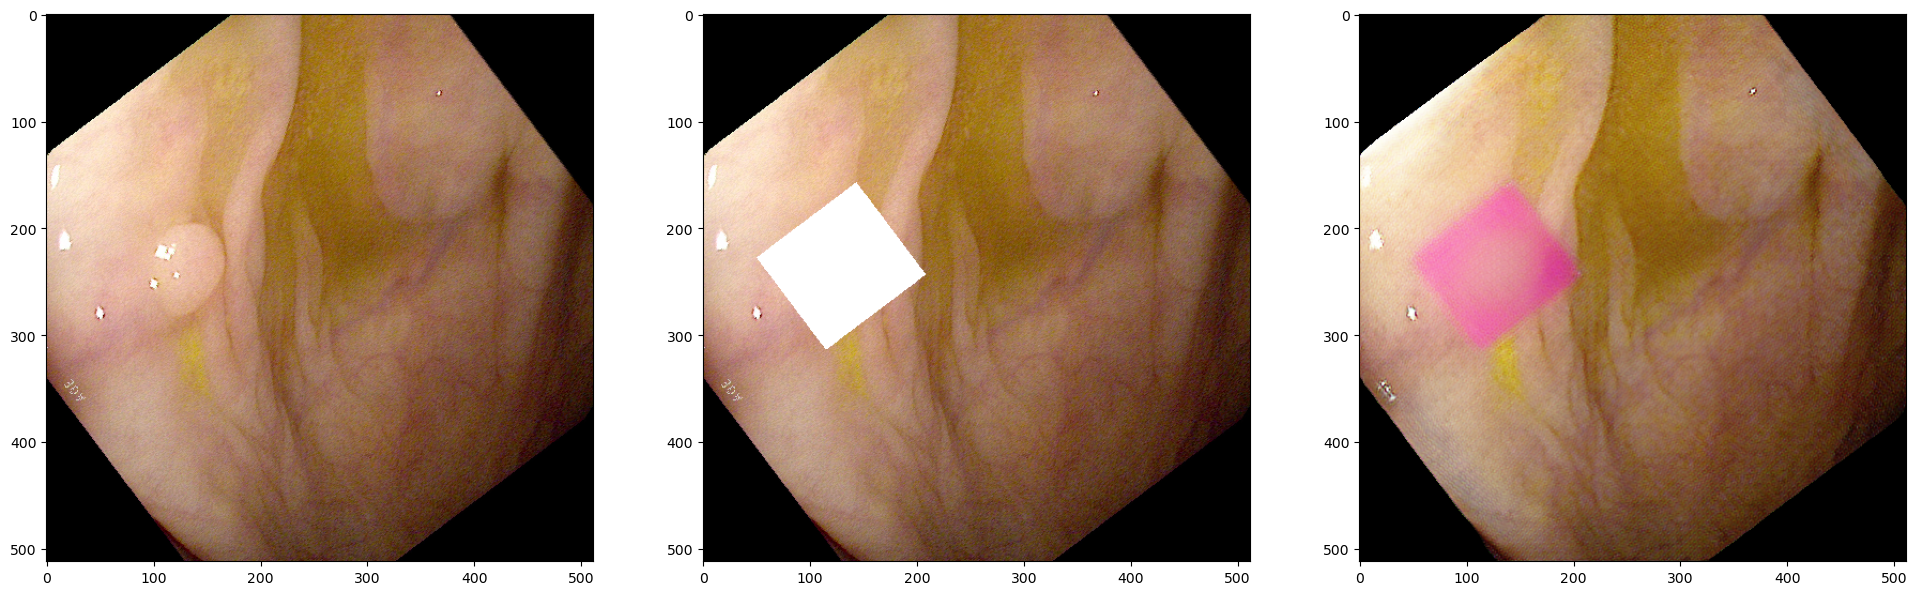

epoch: 57/1000 Step: 51 L1 loss : 0.0883 Style loss: 0.3780 Perceptual loss: 0.2486 advg loss: 0.4172 advd loss: 0.1962: 100%|██████████| 50/50 [01:01<00:00,  1.22s/it]
epoch: 58/1000 Step: 51 L1 loss : 0.0934 Style loss: 0.4189 Perceptual loss: 0.2545 advg loss: 0.4174 advd loss: 0.1957: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]
epoch: 59/1000 Step: 44 L1 loss : 0.0874 Style loss: 0.3891 Perceptual loss: 0.2509 advg loss: 0.4169 advd loss: 0.1960:  86%|████████▌ | 43/50 [00:53<00:08,  1.26s/it]

In [5]:

for epoch in range(params['epochs']):
    train=tqdm(train_dataloader)
    count=0
    train_L1_loss = 0.0 #예측된 값과 실제 값 사이의 절대값 차이의 평균 계산
    train_Style_loss = 0.0 # 네트워크가 생성한 이미지가 목표 스타일 이미지와 비슷한 텍스처, 색상 분포 및 시각적 패턴 비교
    train_Perceptual_loss = 0.0 #이미지의 전반적인 질감, 형태 및 콘텐츠의 유사성을 측정
    train_advg_loss = 0.0
    train_advd_loss = 0.0
    sum_loss= 1000.0
    for images, masks,filename in train:
        count+=1
        images, masks = images.to(device), masks.to(device)
        images_masked = (images * (1 - masks).float()) + masks
        pred_img = netG(images_masked, masks)
        comp_img = (1 - masks) * images + masks * pred_img
        losses = {}
        for name, weight in params['rec_loss'].items():
            losses[name] = weight * rec_loss_func[name](pred_img, images)
        dis_loss, gen_loss = adv_loss(netD, comp_img, images, masks)
        losses["advg"] = gen_loss
        # backforward
        optimG.zero_grad()
        optimD.zero_grad()
        sum(losses.values()).backward()
        losses["advd"] = dis_loss
        dis_loss.backward()
        optimG.step()
        optimD.step()
        train_L1_loss+=losses['L1'].item()
        train_Style_loss+=losses['Style'].item()
        train_Perceptual_loss+=losses['Perceptual'].item()
        train_advg_loss+=losses['advg'].item()
        train_advd_loss+=losses['advd'].item()
        train.set_description(f"epoch: {epoch+1}/{params['epochs']} Step: {count+1} L1 loss : {train_L1_loss/count:.4f} Style loss: {train_Style_loss/count:.4f} Perceptual loss: {train_Perceptual_loss/count:.4f} advg loss: {train_advg_loss/count:.4f} advd loss: {train_advd_loss/count:.4f}")
    if epoch % 10 ==5:
        ax=plt.figure(figsize=(24,8))
        ax.add_subplot(1,3,1)
        plt.imshow(np.transpose(images[0].cpu().detach().numpy(),(1,2,0))/2+0.5)
        ax.add_subplot(1,3,2)
        plt.imshow(np.transpose(images_masked[0].cpu().detach().numpy(),(1,2,0))/2+0.5)
        ax.add_subplot(1,3,3)
        plt.imshow(np.transpose(pred_img[0].cpu().detach().numpy(),(1,2,0))/2+0.5)
        plt.show()
        
    if sum_loss>sum(losses.values()):
        sum_loss=sum(losses.values())
        torch.save(netG.state_dict(), '../../model/aot-model_colon/generator_check.pt')
        torch.save(netD.state_dict(), '../../model/aot-model_colon/discriminator_check.pt')   
torch.save(netG.state_dict(), '../../model/aot-model_colon/generator.pt')
torch.save(netD.state_dict(), '../../model/aot-model_colon/discriminator.pt')   